In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, segmentation, color
from skimage.io import imread_collection

In [2]:
#read data

images_collection = imread_collection('data/*')

num_of_images=len(images_collection)
images = []
plt.figure(figsize=(20, 15))
for (image,i) in zip (images_collection,range(1,num_of_images+1)):

    if image.shape[0] < image.shape[1]:
        image = np.rot90(image)
    images.append(image)
    
    # plt.subplot(int(np.ceil(num_of_images/3)),3,i)
    # plt.title(image.shape)
    # plt.imshow(image,cmap="gray")


<Figure size 1440x1080 with 0 Axes>

In [3]:
#show images histograms

# plt.figure(figsize=(20, 15))

# for (image,i) in zip (images,range(1,num_of_images+1)):
    
#     plt.subplot(int(np.ceil(num_of_images/2)),4,2*i-1)
#     plt.imshow(image,cmap='gray')
#     plt.subplot(int(np.ceil(num_of_images/2)),4,2*i)
#     plt.hist(image.ravel(),256,[0,256]); 

In [4]:
# -------------------- A: Brightness Filter ------------------

def brightness(src, b):
  bright = src + b
  bright[bright > 255] = 255
  bright[bright < 0] = 0
  return bright.astype(np.uint8)

# -------------------- B: Contrast Filter --------------------

def contrast(src, a):
  cont = (src * a)
  cont[cont > 255] = 255
  if cont.max() < 255:
    cont[0,0] = 255
  return cont.astype(np.uint8)

# -------------------- C: Threshold Filter -------------------

def threshold(src, t):
  th, dst = cv2.threshold(src, t, 255, cv2.THRESH_BINARY)
  return dst.astype(np.uint8)

# -------------------- D: Gamma Correction filter ------------

def gamma(src, g):
  dst = 255*((src/255)**(1/g))
  return dst.astype(np.uint8)

In [5]:
# plt.figure(figsize=(8,8))
# plt.imshow(brightness(contrast(images[1], 0.01), 150), cmap="gray")

In [6]:
def dilation(image, iter=1):
    kernel7 = np.ones((7, 7)).astype(np.uint8)
    kernel7[0:2,0:2] = [[0, 0], [0, 1]]
    kernel7[0:2,5:7] = [[0, 0], [1, 0]]
    kernel7[5:7,0:2] = [[0, 1], [0, 0]]
    kernel7[5:7,5:7] = [[1, 0], [0, 0]]
    kernel7 = 1 - kernel7
    dilate7 = cv2.dilate(image, kernel7, iterations=iter)
    return dilate7
def erosion(image, iter=1):
    kernel7 = np.ones((7, 7)).astype(np.uint8)
    kernel7[0:2,0:2] = [[0, 0], [0, 1]]
    kernel7[0:2,5:7] = [[0, 0], [1, 0]]
    kernel7[5:7,0:2] = [[0, 1], [0, 0]]
    kernel7[5:7,5:7] = [[1, 0], [0, 0]]
    kernel7 = 1 - kernel7
    dilate7 = cv2.erode(image, kernel7, iterations=iter)
    return dilate7

In [7]:
def clear_margins(image, show_analytics=False):
    

    th_first = 25
    th_second = 175

    out2 = image.copy().astype(np.uint8)
    out3 = image.copy().astype(np.uint8)
    out3*=0

    canny_edge = cv2.Canny(erosion(dilation(image, 7), 8), th_first, th_second, apertureSize=3, L2gradient=False)
    canny_edge = dilation(canny_edge, 10)
    lines = cv2.HoughLinesP(canny_edge, 1, np.pi/180, 240,  minLineLength=1300, maxLineGap=100)
    if lines is None or len(lines) < 4:
        return -1
    rel_lines = lines[0:4].copy()
    rel_lines *= 0
    rel_lines -= 1

    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if np.abs(y1-y2) < 75: 
            cv2.line(out3, (x1, y1), (x2, y2), (255, 0, 0), 3)
            if (y1 < 1000):
                x1_, y1_, x2_, y2_ = rel_lines[0][0]
                if(y1 > y1_ or y1_ == -1):
                    rel_lines[0] = line
            elif (y1 > image.shape[0]-1000):
                x1_, y1_, x2_, y2_ = rel_lines[1][0]
                if(y1 < y1_ or y1_ == -1):
                    rel_lines[1] = line  
        if (np.abs(x1-x2) < 75):
            cv2.line(out3, (x1, y1), (x2, y2), (255, 0, 0), 3)
            if (x1 < 500):
                x1_, y1_, x2_, y2_ = rel_lines[2][0]
                if(x1 > x1_ or x1_ == -1):
                    rel_lines[2] = line
            elif (x1 > image.shape[1]-500):
                x1_, y1_, x2_, y2_ = rel_lines[3][0]
                if(x1 < x1_ or x1_ == -1):
                    rel_lines[3] = line 


    

    x1_, y1_, x2_, y2_ = rel_lines[0][0]
    out2[:y1_, :] = 255
    x1_, y1_, x2_, y2_ = rel_lines[1][0]
    out2[y1_:, :] = 255
    x1_, y1_, x2_, y2_ = rel_lines[2][0]
    out2[:, :x1_] = 255
    x1_, y1_, x2_, y2_ = rel_lines[3][0]
    out2[:, x1_:] = 255

    if show_analytics:
        plt.figure(figsize=(30, 30))
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")

        plt.subplot(2, 2, 2)
        plt.imshow(canny_edge, cmap="gray")

        plt.subplot(2, 2, 3)
        plt.imshow(out3, cmap="gray")

        plt.subplot(2, 2, 4)
        plt.imshow(np.bitwise_or(image, out2), cmap="gray")


    return out2
    # return out3

# i = clear_margins(images[1], True)


In [8]:
image_cleen=[]
plt.figure(figsize=(15, 50))

for (image,i) in zip (images,range(1,num_of_images+1)):

    # th_first = 50
    # th_second = 150
    # out1 = cv2.Canny(image, th_first, th_second, apertureSize=3, L2gradient=False)
    # out1 = dilation(dilation(dilation(out1)))
    
    # plt.subplot(num_of_images,2,2*i-1)
    # plt.imshow(image,cmap='gray')
    # plt.subplot(num_of_images,2,2*i)
    # plt.imshow(clear_margins(image),cmap='gray')
    image_cleen.append(clear_margins(image))


<Figure size 1080x3600 with 0 Axes>

In [9]:

def region_filling(img):
kernel3 = np.zeros((3,3)).astype(np.uint8)
kernel3[1, :] = 1
kernel3[:, 1] = 1

h, w = img.shape
region_fill = np.zeros((h, w)).astype(np.uint8)
region_fill[1,1] = 255
region_fill[h-2,1] = 255
region_fill[1,w-2] = 255
region_fill[h-2,w-2] = 255

dst_invert = np.invert(dst)

while True:
    tmp = cv2.dilate(region_fill, kernel3, iterations=1)
    tmp = (tmp & dst_invert).astype(np.uint8)
    if np.sum(np.abs(region_fill-tmp)) == 0:
        break
    region_fill = tmp

    return x_finel

In [10]:
plt.figure(figsize=(25, 75))
th_first = 75
th_second = 200
edges=[]

for (image,i) in zip (image_cleen,range(1,num_of_images+1)):
    # plt.subplot(num_of_images,4,4*i-3)
    image_contrast = contrast(image,1.5)
    # plt.imshow(image,cmap='gray')

    # plt.subplot(num_of_images,4,4*i-2)
    canny_edge=cv2.GaussianBlur(image_contrast,(25,25),cv2.BORDER_DEFAULT)
    dilat = dilation(cv2.bitwise_not(canny_edge),3)
    # plt.imshow(dilat,cmap="gray")
   

    # plt.subplot(num_of_images,4,4*i-1)
    
    
    canny_edge = cv2.Canny(image_contrast, th_first, th_second, apertureSize=3, L2gradient=False)
    canny_edge = dilation(canny_edge, 5)
   
    # plt.imshow(canny_edge,cmap="gray")
    # plt.subplot(num_of_images,4,4*i)
    res=canny_edge-dilat
    res[res<254]=0

    res=cv2.bitwise_not(res)
    canny_edge[res<100]=0
    res=canny_edge-dilat
    res[res<254]=0
    # res2 = region_filling(res)
    edges.append(res)
    # plt.imshow(dilation(res2,2),cmap="gray")
    

<Figure size 1800x5400 with 0 Axes>

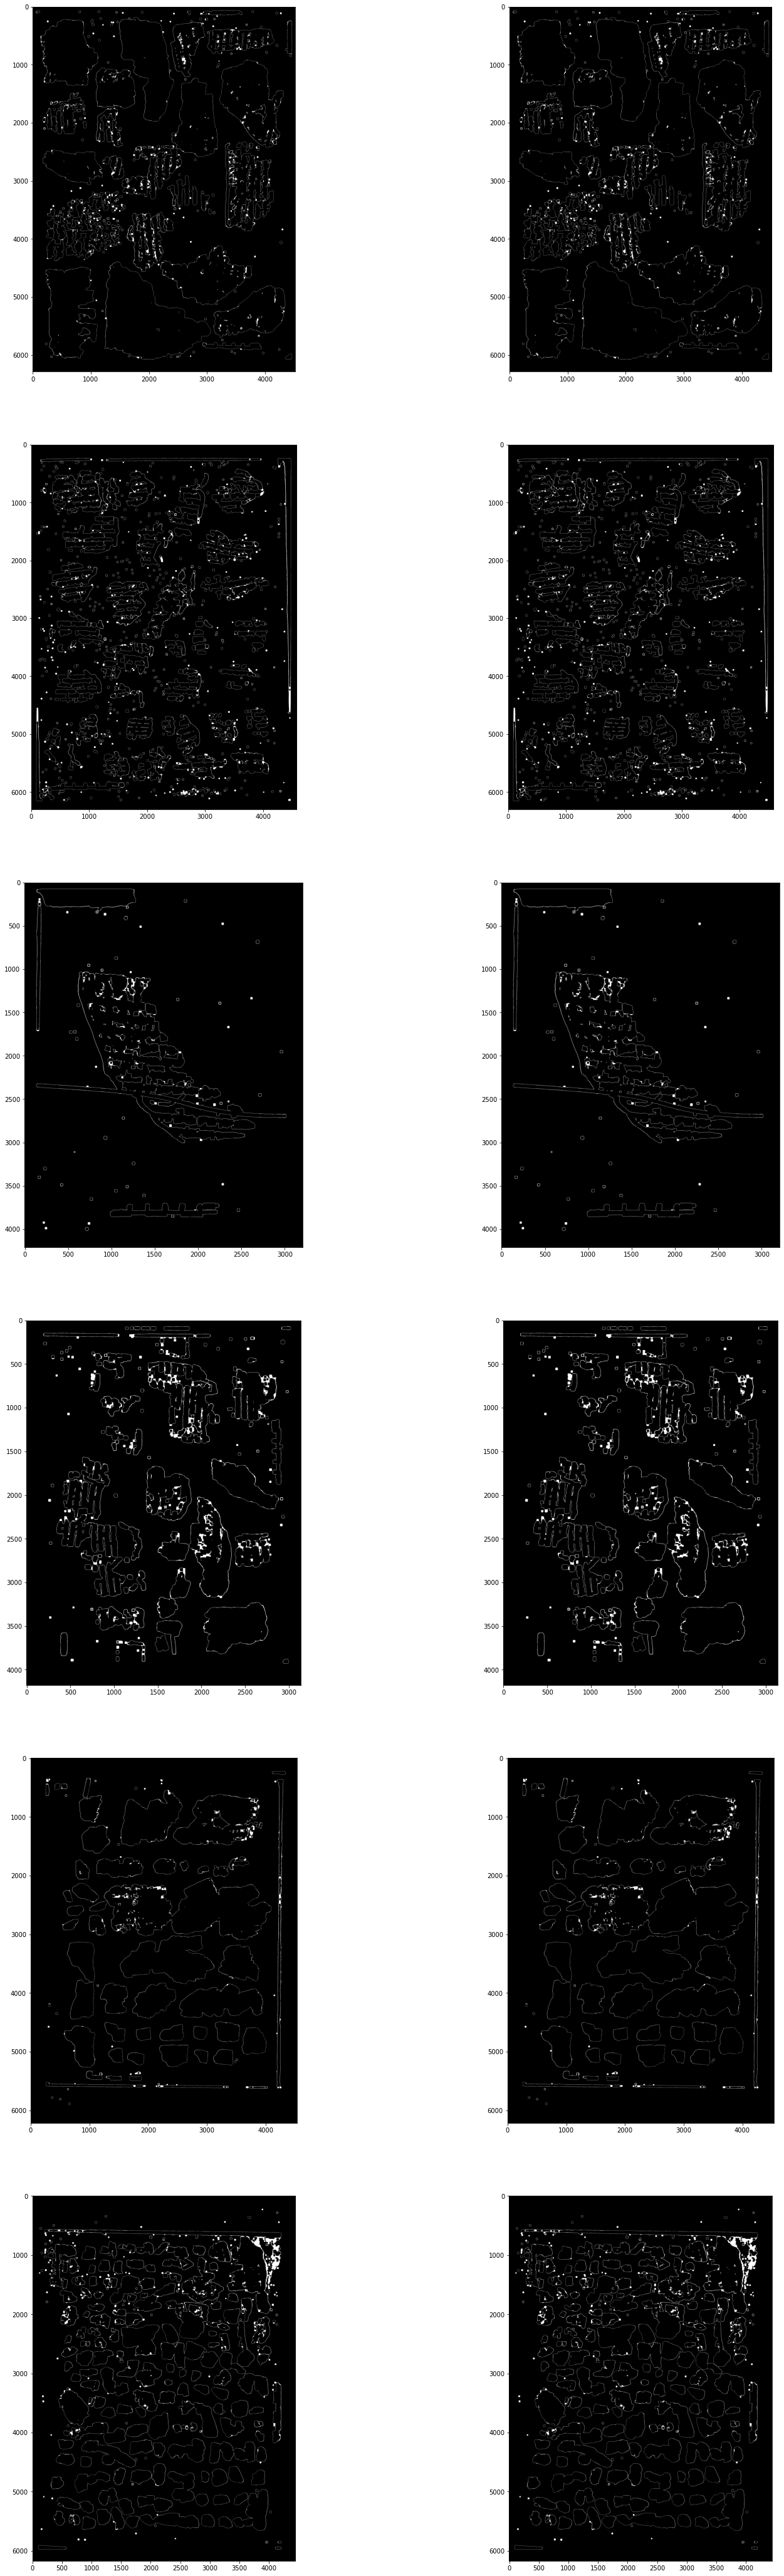

In [14]:
plt.figure(figsize=(25, 75))
for (image,i) in zip (edges,range(1,num_of_images+1)):
    plt.subplot(num_of_images,2,2*i-1)
    
    plt.imshow(image,cmap='gray')
   
    plt.subplot(num_of_images,2,2*i)
    # res=region_filling(image)
    plt.imshow(image,cmap='gray')

    

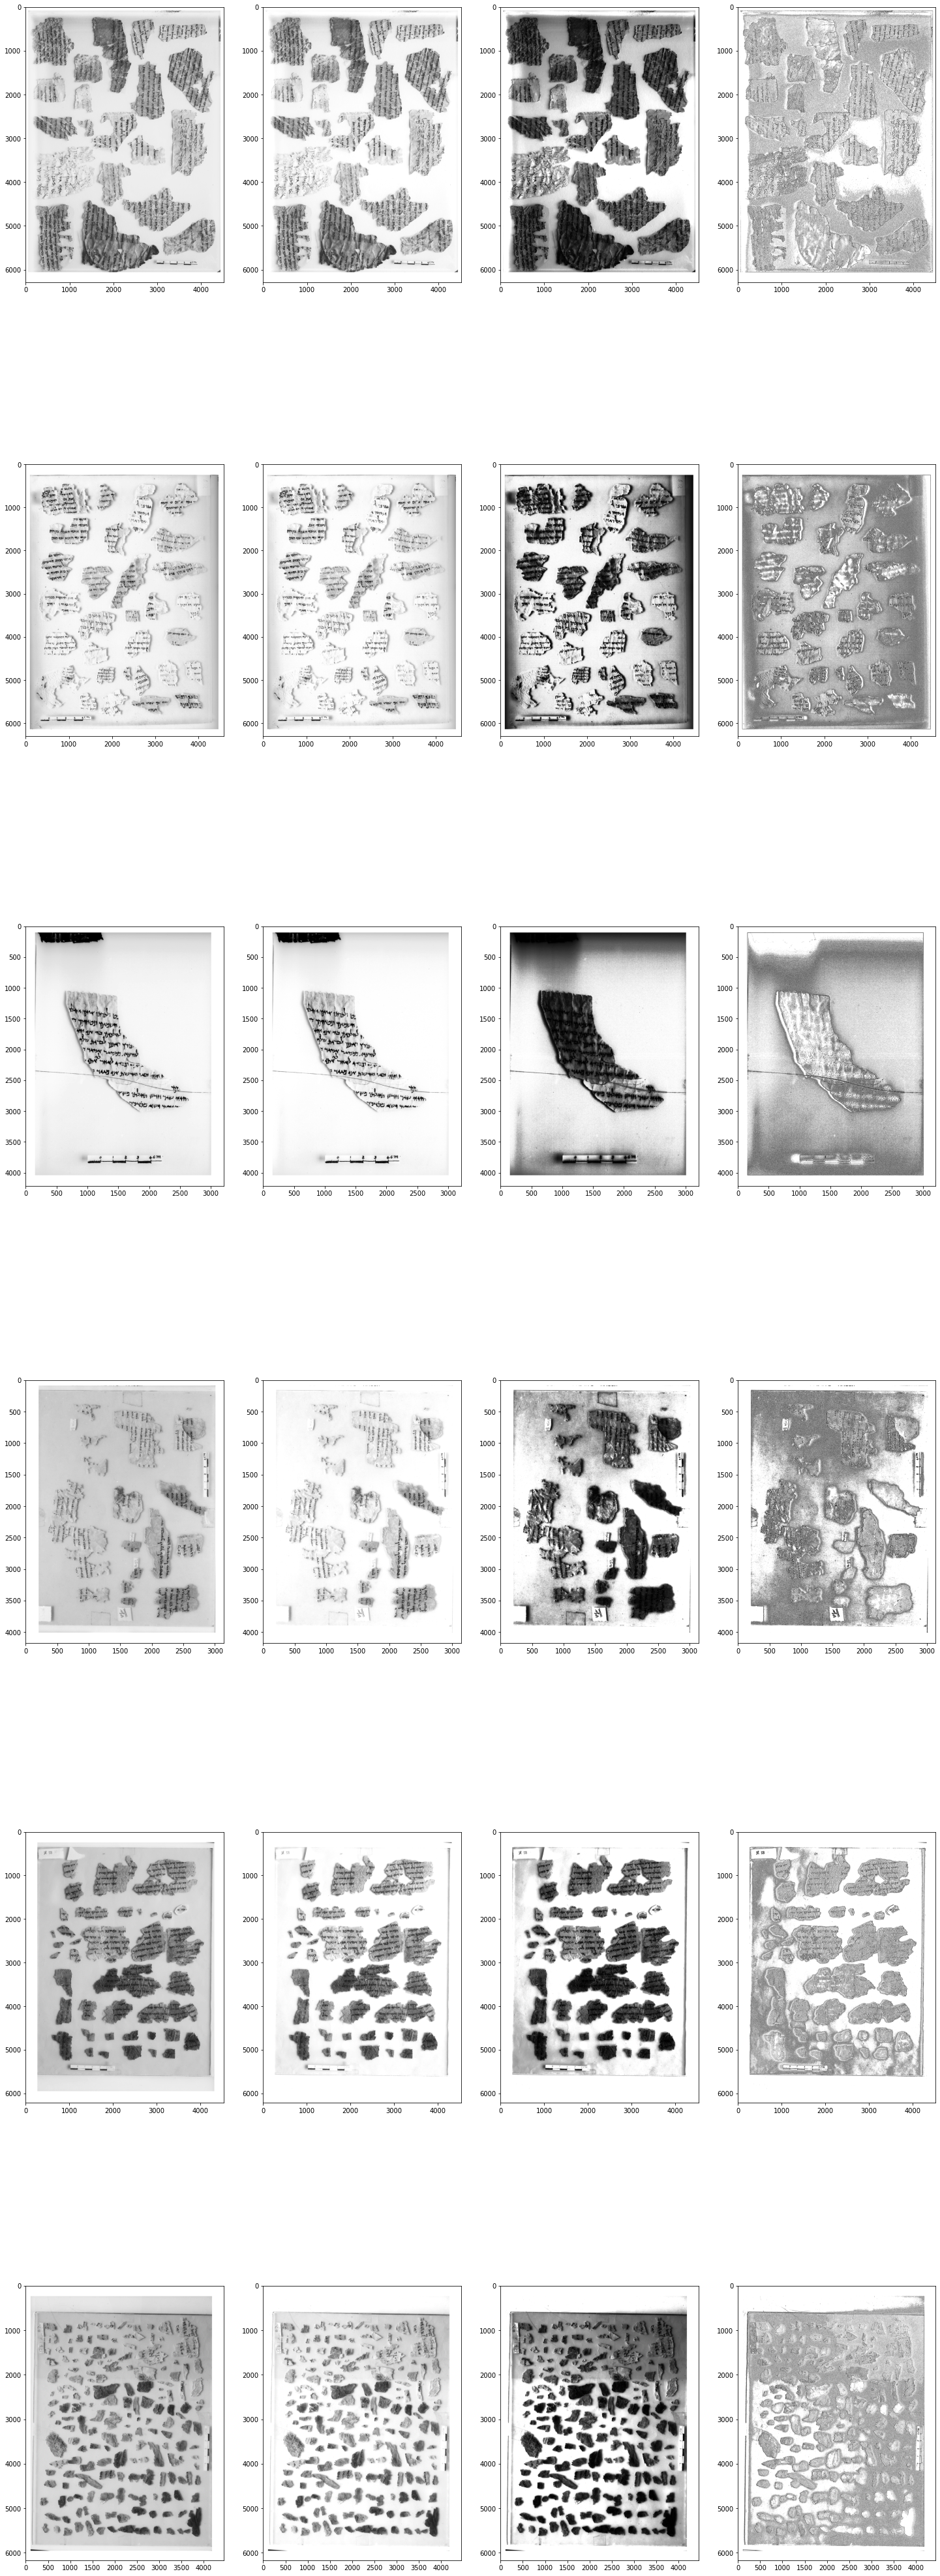

In [30]:

plt.figure(figsize=(25, 75))
for (image,i) in zip (image_cleen,range(1,num_of_images+1)):

    plt.subplot(num_of_images,4,4*i-3)
    plt.imshow(image,cmap='gray')

    plt.subplot(num_of_images,4,4*i-2)
    hist, bins = np.histogram(image,bins=range(256))
    th=np.argmax(hist[0:254]) 
    x=254/th
    res=contrast(image,x)
    plt.imshow(res,cmap='gray')
    
    plt.subplot(num_of_images,4,4*i-1)
    median = cv2.equalizeHist(res)
       
    hist, bins = np.histogram(median,bins=range(256))
    th=np.argmax(hist[0:254]) 
    x=254/th
    res=contrast(median,x)

    hist, bins = np.histogram(res,bins=range(256))
    th=np.argmax(hist[0:254]) 
    x=254/th
    res=contrast(res,x)

    plt.imshow(res,cmap='gray')

    plt.subplot(num_of_images,4,4*i)
    median = cv2.equalizeHist(res)
   
    plt.imshow(median,cmap='gray')
    # plt.hist(res.ravel(),256,[0,256]); 
    # dilait=dilation(res,5)
    # erode=erosion(dilait,1)
    # erodila = erode-dilait
    # blur=cv2.GaussianBlur(erodila,(5,5),0)

In [ ]:
# th_back_black=0
# th_back_white=0

# th_back_black=0

# plt.figure(figsize=(10, 30))
# th_images=[]
# for (image,i) in zip (images,range(1,num_of_images+1)):
#     plt.subplot(num_of_images, 2, 2*i-1)
#     plt.imshow(image,cmap="gray")
    
#     hist, bins = np.histogram(image,bins=range(256)); 
#     th_back_black = np.argmax(hist[0:50]) + 100
#     th_back_white =  np.argmax(hist[200:255]) + 150
#     # print(th_back_black, th_back_white)
#     image[image < th_back_black] = 255
#     image[0,0] = 0
#     plt.subplot(num_of_images, 2, 2*i)
#     plt.title(image.shape)
#     plt.imshow(image,cmap="gray")
#     th_images.append(image)

In [ ]:
# kernel7 = np.ones((7, 7)).astype(np.uint8)
# kernel7[0:2,0:2] = [[0, 0], [0, 1]]
# kernel7[0:2,5:7] = [[0, 0], [1, 0]]
# kernel7[5:7,0:2] = [[0, 1], [0, 0]]
# kernel7[5:7,5:7] = [[1, 0], [0, 0]]
# kernel7 = 1 - kernel7


# def find_edges(img):

#     kernel7 = np.ones((7, 7)).astype(np.uint8)
#     kernel7[0:2,0:2] = [[0, 0], [0, 1]]
#     kernel7[0:2,5:7] = [[0, 0], [1, 0]]
#     kernel7[5:7,0:2] = [[0, 1], [0, 0]]
#     kernel7[5:7,5:7] = [[1, 0], [0, 0]]
#     kernel7 = 1 - kernel7

#     # get edges by subtracting dilation and erosion
#     dilate7 = cv2.dilate(img, kernel7, iterations=1)
#     erode7 = cv2.erode(img, kernel7, iterations=1)
#     th, dst = cv2.threshold(dilate7-erode7, 50, 255, cv2.THRESH_BINARY)

#     return dst

In [ ]:
# image = images[3]
# h, w = image.shape
# out1 = image.copy()
# out2 = out3 = image.copy()
# out2*=0
# out3*=0

# # out1 = cv2.GaussianBlur(out1,(9,9),cv2.BORDER_DEFAULT)
# # out1 = cv2.GaussianBlur(out1,(9,9),cv2.BORDER_DEFAULT)
# out1 = cv2.fastNlMeansDenoising(out1, h = 7)
# out3 = cv2.adaptiveThreshold(out1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
# T_, out1 = cv2.threshold(out1, 0, 170, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# out1 = cv2.Canny(out1, 130, 255, 1)




# out1 = cv2.GaussianBlur(out1,(11, 11),cv2.BORDER_DEFAULT)

# out2 = find_edges(out1)


# lines = cv2.HoughLinesP(out2, 1, np.pi/180, 240,  minLineLength=10, maxLineGap=100)

# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(out3, (x1, y1), (x2, y2), (255, 0, 0), 3)


# plt.figure(figsize=(15, 30))
# plt.subplot(2, 2, 1)
# plt.imshow(image, cmap="gray")

# plt.subplot(2, 2, 2)
# plt.imshow(out1, cmap="gray")

# plt.subplot(2, 2, 3)
# plt.imshow(out2, cmap="gray")

# plt.subplot(2, 2, 4)
# plt.imshow(out3, cmap="gray")



# plt.show()

In [ ]:
# plt.figure(figsize=(15, 20))


# dst = cv2.GaussianBlur(images[4],(5,5),cv2.BORDER_DEFAULT)

# plt.title(images[4].shape)
# plt.imshow(dst, cmap='gray')
# plt.show()

# plt.figure(figsize=(15, 20))
# output = find_edges(images[4] - dst)
# # output = find_edges(dst)
# cpy = output.copy()
# cpy*=0
# lines = cv2.HoughLinesP(output, 1, np.pi/180, 240,  minLineLength=int(w * 0.8), maxLineGap=int(w * 0.1))
# # Draw lines on the image
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(cpy, (x1, y1), (x2, y2), (255, 0, 0), 3)
# plt.title(dst.shape)
# plt.imshow(cpy, cmap='gray')
# plt.show()